In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:03:01   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

KeyError: 0

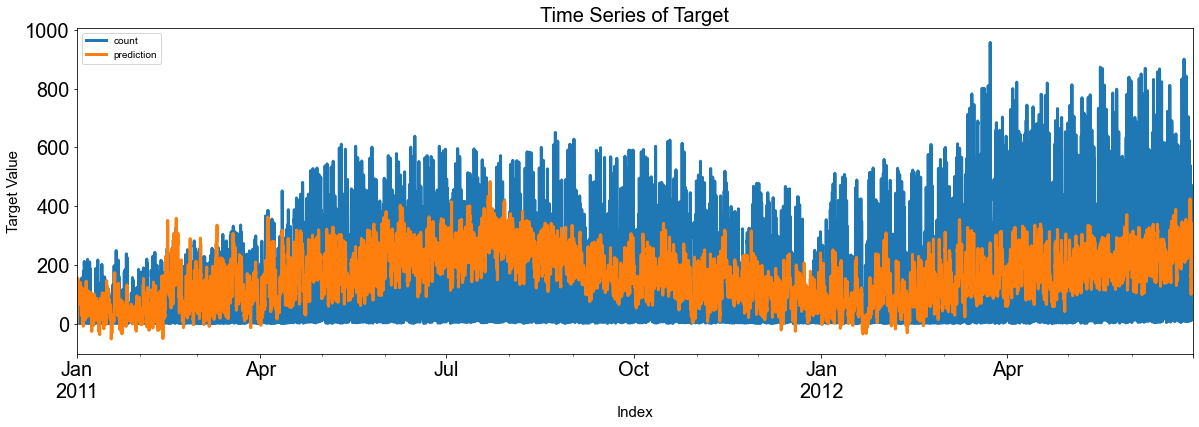

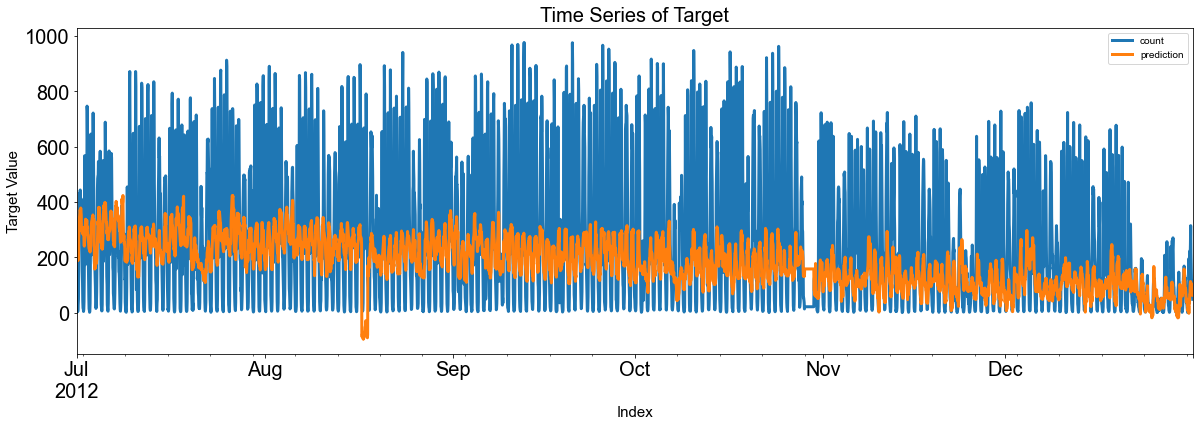

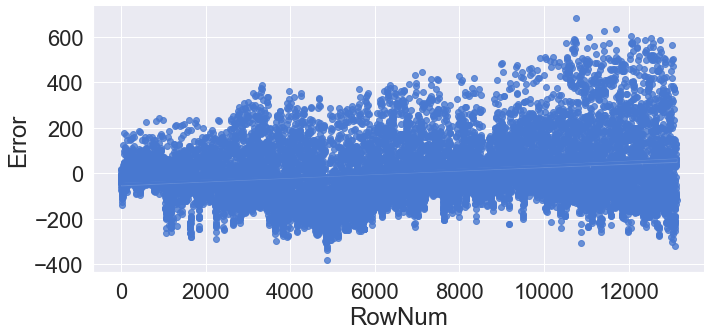

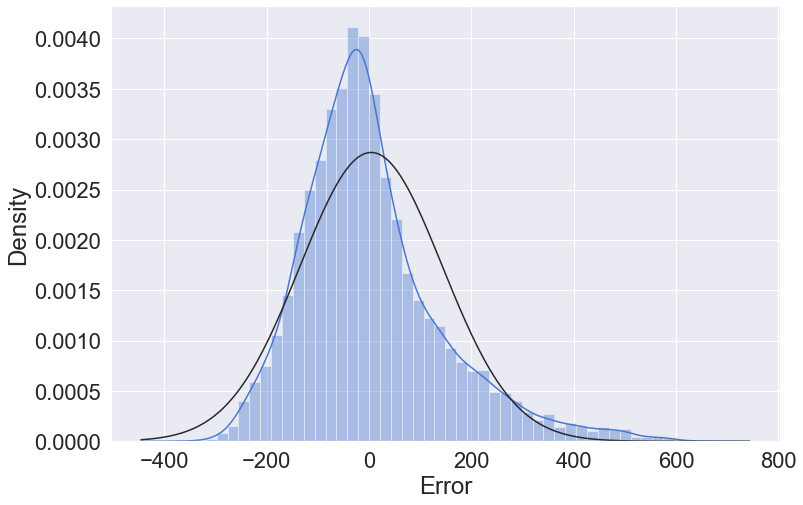

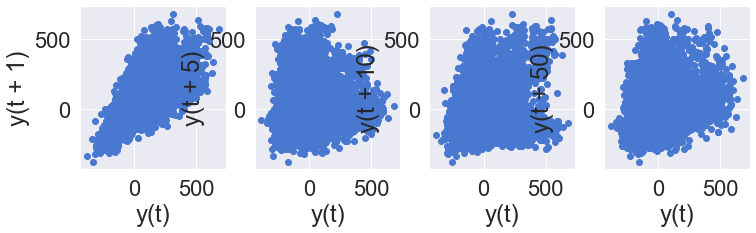

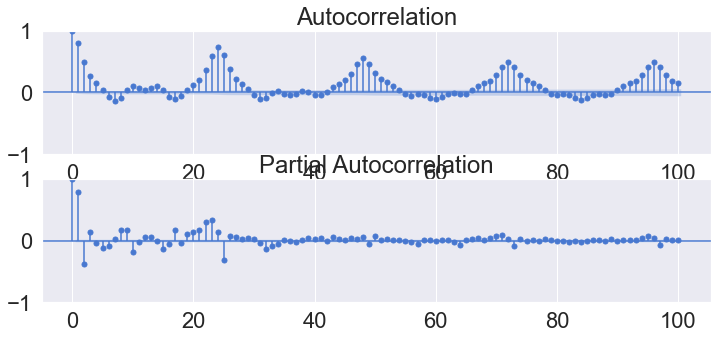

In [3]:
raw_all = pd.read_csv('bike-sharing-demand/Full.csv')
raw_rd = non_feature_engineering(raw_all)

Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_rd.columns if x not in Y_colname+X_remove]
X_train_rd, X_test_rd, Y_train_rd, Y_test_rd = datasplit_ts(raw_rd, Y_colname, X_colname, '2012-07-01')

fit_reg1_rd = sm.OLS(Y_train_rd, X_train_rd).fit()
display(fit_reg1_rd.summary())
pred_tr_reg1_rd = fit_reg1_rd.predict(X_train_rd).values
pred_te_reg1_rd = fit_reg1_rd.predict(X_test_rd).values

# Evaluation
Score_reg1_rd, Resid_tr_reg1_rd, Resid_te_reg1_rd = evaluation_trte(Y_train_rd, pred_tr_reg1_rd, 
                                                                Y_test_rd, pred_te_reg1_rd, graph_on=True)
display(Score_reg1_rd)

# Error Analysis
error_analysis(Resid_tr_reg1_rd, ['Error'], X_train_rd, graph_on=True)

Train_size: (13128, 30) Test_size: (4416, 30)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:03:13   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.832
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

KeyError: 0

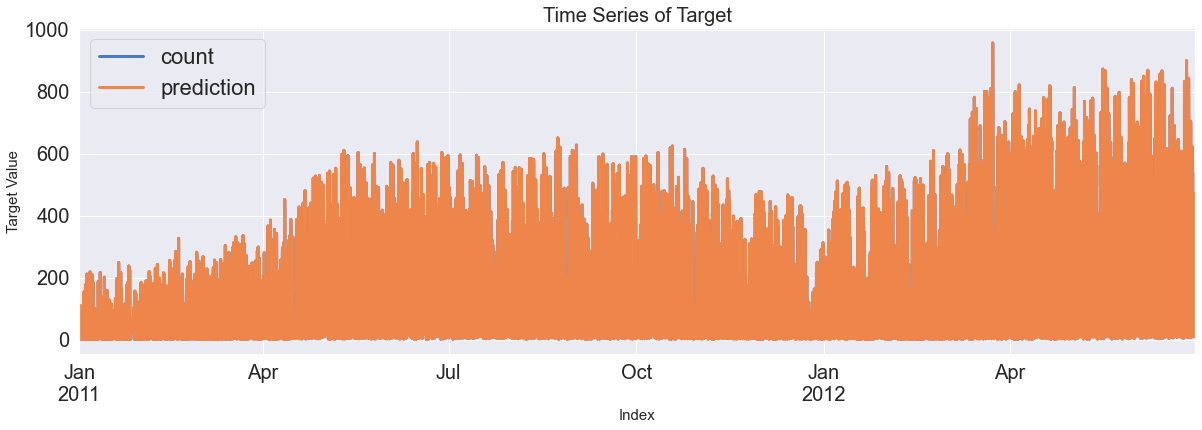

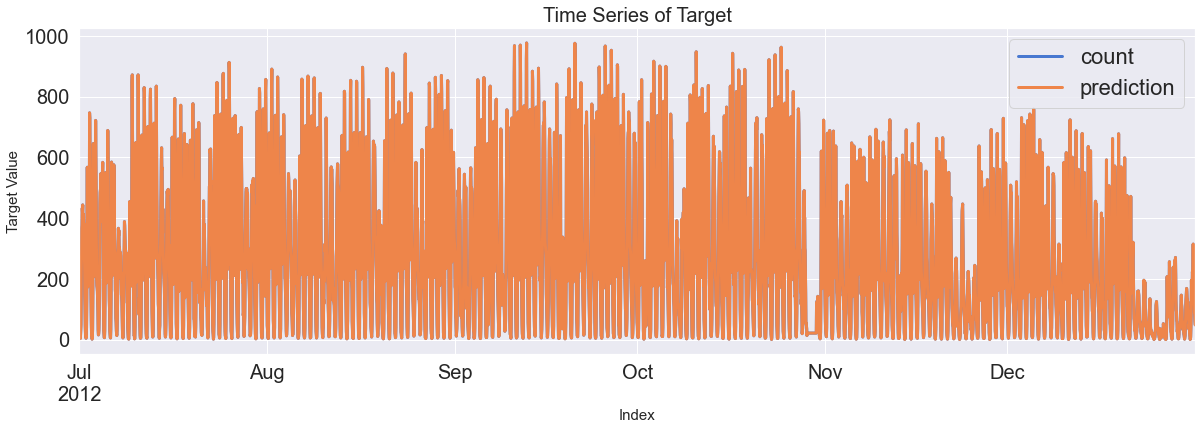

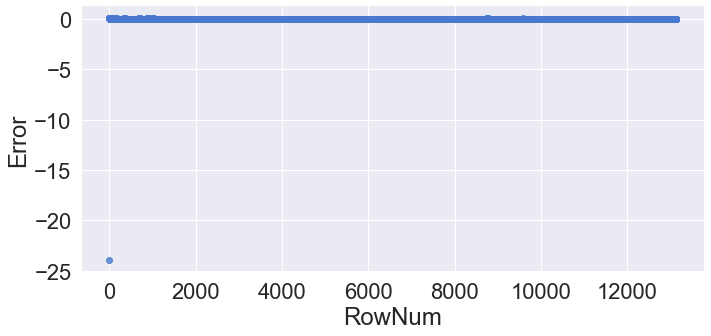

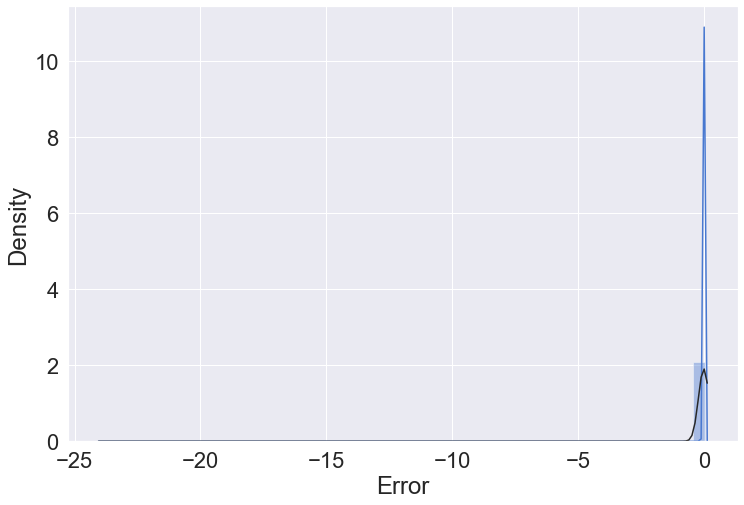

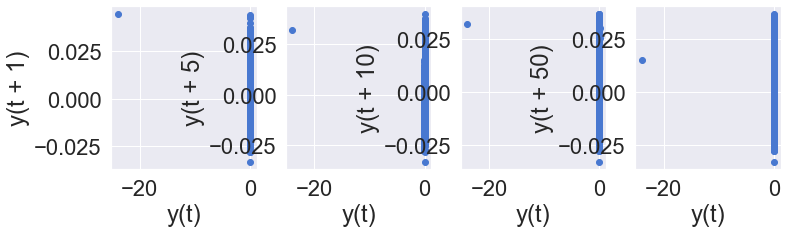

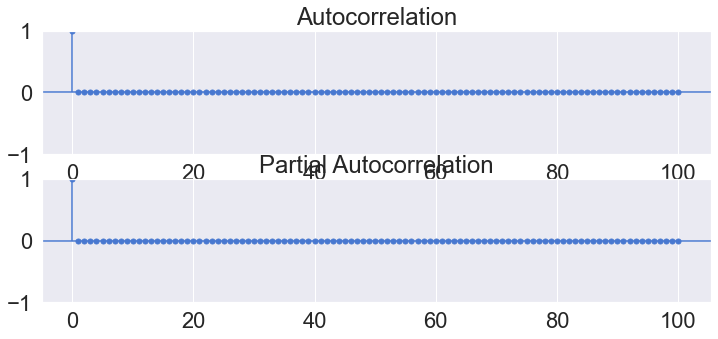

In [4]:
raw_fe = feature_engineering(raw_all)

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

# Applying Base Model
fit_reg1_fe = sm.OLS(Y_train_fe, X_train_fe).fit()
display(fit_reg1_fe.summary())
pred_tr_reg1_fe = fit_reg1_fe.predict(X_train_fe).values
pred_te_reg1_fe = fit_reg1_fe.predict(X_test_fe).values

# Evaluation
Score_reg1_fe, Resid_tr_reg1_fe, Resid_te_reg1_fe = evaluation_trte(Y_train_fe, pred_tr_reg1_fe,
                                                                Y_test_fe, pred_te_reg1_fe, graph_on=True)
display(Score_reg1_fe)

# Error Analysis
error_analysis(Resid_tr_reg1_fe, ['Error'], X_train_fe, graph_on=True)

In [ ]:
display(Score_reg1_rd)
display(Score_reg1_fe)

In [ ]:
# 3.1 시간현실반영
raw_fe.head()

In [ ]:
raw_fe['count_trend'].plot()
'''
우리는 현재 데이터에서 2011~2012을 학습 데이터로 2012~2013년을 테스트 데이터로 사용하였다.
여기서 미래정보는 알지 못 하지만 우리는 미래 정보를 안다는 가정하에 실험을 진행했기 때문에
오버피팅이 발생하여 조금의 튜닝이 필요하다.
'''

In [ ]:
'''
튜닝 과정
학습 데이터와 실험 데이터의 패턴을 알기 위해서 2가지 패턴을 나타냄 그래프
'''
raw_fe.loc[X_train_fe.index, 'count_trend'].plot()
plt.show()

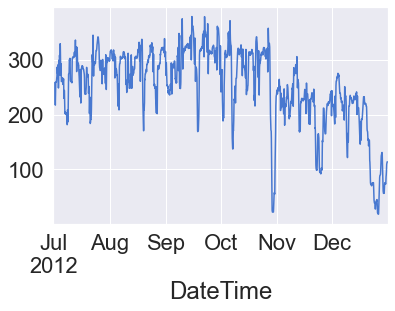

In [5]:
raw_fe.loc[X_test_fe.index, 'count_trend'].plot()
plt.show()

In [6]:
len(raw_fe.loc['2012-01-01':'2012-12-31', 'count_trend'])

8784

In [7]:
len(raw_fe.loc['2011-01-01':'2011-12-31', 'count_trend'])

8760

In [8]:
'''
가정: 2011년도 데이터 패턴이 2012년도에 그대로 반영된다는 가정하에 실험을 진행함
'''
raw_fe.loc['2012-01-01':'2012-02-28', 'count_trend'] = raw_fe.loc['2011-01-01':'2011-02-28', 'count_trend'].values
raw_fe.loc['2012-03-01':'2012-12-31', 'count_trend'] = raw_fe.loc['2011-03-01':'2011-12-31', 'count_trend'].values
# 2012-02-29??
# raw_fe.loc['2012-02-27':'2012-03-03', 'count_trend']
# raw_fe.loc['2012-02-28':'2012-03-01', 'count_trend']
# raw_fe.loc['2012-02-28 23:00:00', 'count_trend']
# raw_fe.loc['2012-03-01 00:00:00', 'count_trend']
step = (raw_fe.loc['2011-03-01 00:00:00', 'count_trend'] - raw_fe.loc['2011-02-28 23:00:00', 'count_trend'])/25
step_value = np.arange(raw_fe.loc['2011-02-28 23:00:00', 'count_trend']+step, 
                       raw_fe.loc['2011-03-01 00:00:00', 'count_trend'], step)
step_value = step_value[:24]
raw_fe.loc['2012-02-29', 'count_trend'] = step_value

In [9]:
raw_fe.loc['2012-02-28 22:00:00':'2012-03-01 02:00:00', 'count_trend']

DateTime
2012-02-28 22:00:00   57.62
2012-02-28 23:00:00   56.48
2012-02-29 00:00:00   56.49
2012-02-29 01:00:00   56.51
2012-02-29 02:00:00   56.53
2012-02-29 03:00:00   56.54
2012-02-29 04:00:00   56.56
2012-02-29 05:00:00   56.57
2012-02-29 06:00:00   56.59
2012-02-29 07:00:00   56.61
2012-02-29 08:00:00   56.62
2012-02-29 09:00:00   56.64
2012-02-29 10:00:00   56.65
2012-02-29 11:00:00   56.67
2012-02-29 12:00:00   56.68
2012-02-29 13:00:00   56.70
2012-02-29 14:00:00   56.72
2012-02-29 15:00:00   56.73
2012-02-29 16:00:00   56.75
2012-02-29 17:00:00   56.76
2012-02-29 18:00:00   56.78
2012-02-29 19:00:00   56.80
2012-02-29 20:00:00   56.81
2012-02-29 21:00:00   56.83
2012-02-29 22:00:00   56.84
2012-02-29 23:00:00   56.86
2012-03-01 00:00:00   56.88
2012-03-01 01:00:00   58.88
2012-03-01 02:00:00   60.96
Freq: H, Name: count_trend, dtype: float64

<AxesSubplot:xlabel='DateTime'>

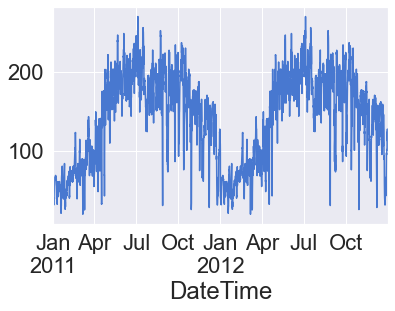

In [10]:
raw_fe['count_trend'].plot()

In [11]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_fe = feature_engineering_year_duplicated(raw_fe, target)

<AxesSubplot:xlabel='DateTime'>

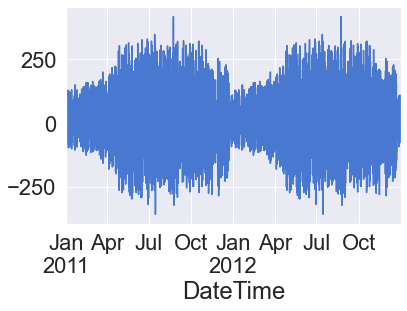

In [12]:
raw_fe['count_diff'].plot()

In [13]:
raw_fe.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,DateTime,count_trend,count_seasonal,count_Day,count_Week,count_diff,temp_group,Year,Quater_ver2,Month,Day,Hour,DayofWeek,count_lag1,count_lag2,Quater_Dummy_2,Quater_Dummy_3,Quater_Dummy_4
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16,2011-01-01 00:00:00,41.06,-134.25,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,0,5,16.00,16.00,0,0,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40,2011-01-01 01:00:00,41.06,-154.75,41.04,56.11,24.00,"(8.856, 12.874]",2011,1,1,1,1,5,16.00,16.00,0,0,0
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32,2011-01-01 02:00:00,41.06,-165.27,41.04,56.11,-8.00,"(8.856, 12.874]",2011,1,1,1,2,5,40.00,16.00,0,0,0
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13,2011-01-01 03:00:00,41.06,-176.48,41.04,56.11,-19.00,"(8.856, 12.874]",2011,1,1,1,3,5,32.00,40.00,0,0,0
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1,2011-01-01 04:00:00,41.06,-181.67,41.04,56.11,-12.00,"(8.856, 12.874]",2011,1,1,1,4,5,13.00,32.00,0,0,0


In [14]:
# calculation of lag data from Y
X_test_fe['count_lag1'] = Y_test_fe.shift(1).values
X_test_fe['count_lag1'].fillna(method='bfill', inplace=True)
X_test_fe['count_lag2'] = Y_test_fe.shift(2).values
X_test_fe['count_lag2'].fillna(method='bfill', inplace=True)
X_test_fe['count_lag2']

DateTime
2012-07-01 00:00:00   149.00
2012-07-01 01:00:00   149.00
2012-07-01 02:00:00   149.00
2012-07-01 03:00:00    93.00
2012-07-01 04:00:00    90.00
                       ...  
2012-12-31 19:00:00   164.00
2012-12-31 20:00:00   122.00
2012-12-31 21:00:00   119.00
2012-12-31 22:00:00    89.00
2012-12-31 23:00:00    90.00
Freq: H, Name: count_lag2, Length: 4416, dtype: float64

In [15]:
### Functionalize
### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
target = ['count_lag1', 'count_lag2']
X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

<AxesSubplot:xlabel='DateTime'>

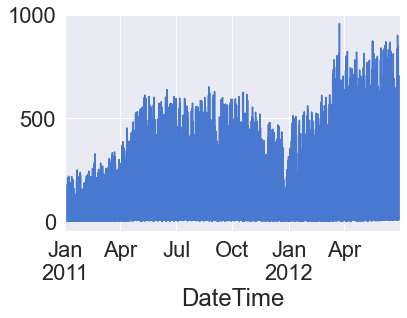

In [16]:
X_train_fe['count_lag2'].plot()

In [17]:
### Functionalize
### duplicate previous year values to next one
def feature_engineering_year_duplicated(raw, target):
    raw_fe = raw.copy()
    for col in target:
        raw_fe.loc['2012-01-01':'2012-02-28', col] = raw.loc['2011-01-01':'2011-02-28', col].values
        raw_fe.loc['2012-03-01':'2012-12-31', col] = raw.loc['2011-03-01':'2011-12-31', col].values
        step = (raw.loc['2011-03-01 00:00:00', col] - raw.loc['2011-02-28 23:00:00', col])/25
        step_value = np.arange(raw.loc['2011-02-28 23:00:00', col]+step, raw.loc['2011-03-01 00:00:00', col], step)
        step_value = step_value[:24]
        raw_fe.loc['2012-02-29', col] = step_value
    return raw_fe
# target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
# raw_fe = feature_engineering_year_duplicated(raw_fe, target)

### modify lagged values of X_test
def feature_engineering_lag_modified(Y_test, X_test, target):
    X_test_lm = X_test.copy()
    for col in target:
        X_test_lm[col] = Y_test.shift(1).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
        X_test_lm[col] = Y_test.shift(2).values
        X_test_lm[col].fillna(method='bfill', inplace=True)
    return X_test_lm
# target = ['count_lag1', 'count_lag2']
# X_test_fe = feature_engineering_lag_modified(Y_test_fe, X_test_fe, target)

Train_size: (13128, 30) Test_size: (4416, 30)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5658.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):               0.00
Time:                        11:03:35   Log-Likelihood:                -69618.
No. Observations:               13128   AIC:                         1.393e+05
Df Residuals:                   13104   BIC:                         1.395e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season             2.7535      0.952      2.893      0.004       0.888       4.619
holiday            0.6180      3.170      0.195      0.845      -5.595       6.831
workingday         2.1960      1.544      1.423      0.155      -0.830       5.222
weather           -5.8817      0.780     -7.544      0.000      -7.410      -4.353
temp               0.5622      0.490      1.146      0.252      -0.399       1.523
atemp              0.4042      0.427      0.946      0.344      -0.433       1.242
humidity          -0.0706      0.028     -2.501      0.012      -0.126      -0.015
windspeed         -0.1216      0.057     -2.117      0.034      -0.234      -0.009
count_trend        0.0718      0.024      3.007      0.003       0.025       0.119
count_seasonal     0.1948      0.006     34.600      0.000       0.184       0.206
count_Day          0.1011      0.024      4.190      0.000       0.054       0.148
count_Week        -0.0801      0.026     -3.078      0.002      -0.131      -0.029
count_diff         0.7146      0.007     97.737      0.000       0.700       0.729
Year               0.0004      0.002      0.188      0.851      -0.003       0.004
Quater_ver2        5.6849      0.284     19.988      0.000       5.127       6.242
Month              1.1013      0.566      1.945      0.052      -0.009       2.211
Day               -0.0335      0.049     -0.681      0.496      -0.130       0.063
Hour               0.1185      0.083      1.420      0.156      -0.045       0.282
DayofWeek          0.3611      0.354      1.021      0.307      -0.332       1.055
count_lag1         0.9285      0.006    149.851      0.000       0.916       0.941
count_lag2        -0.1938      0.006    -33.734      0.000      -0.205      -0.183
Quater_Dummy_2    -7.2671      2.213     -3.284      0.001     -11.605      -2.929
Quater_Dummy_3   -21.5188      3.728     -5.773      0.000     -28.825     -14.212
Quater_Dummy_4   -26.7509      5.511     -4.854      0.000     -37.554     -15.948
==============================================================================
Omnibus:                     3715.248   Durbin-Watson:                   1.582
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           115549.958
Skew:                           0.728   Prob(JB):                         0.00
Kurtosis:                      17.461   Cond. No.                     3.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,27.79,"2,364.05",82.11
Test,113.99,"26,316.17",133.61


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

KeyError: 0

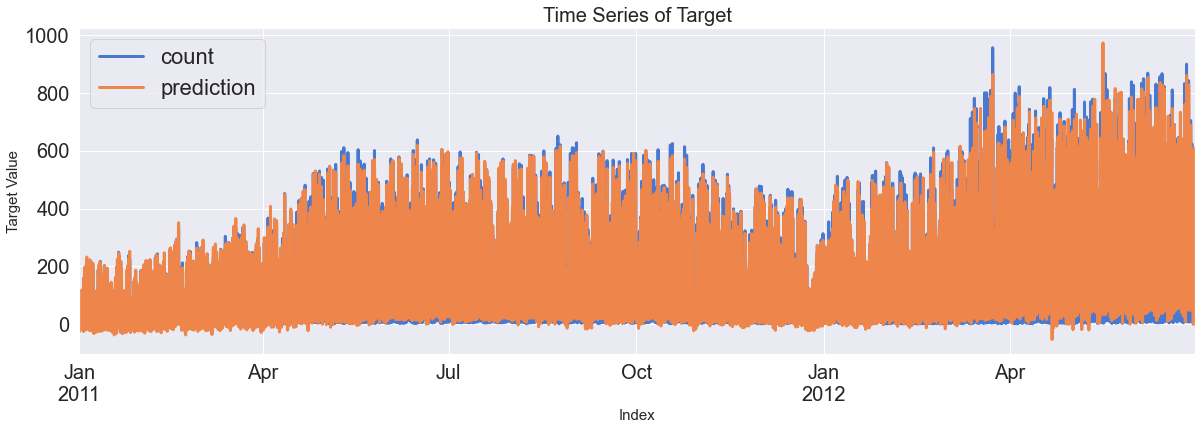

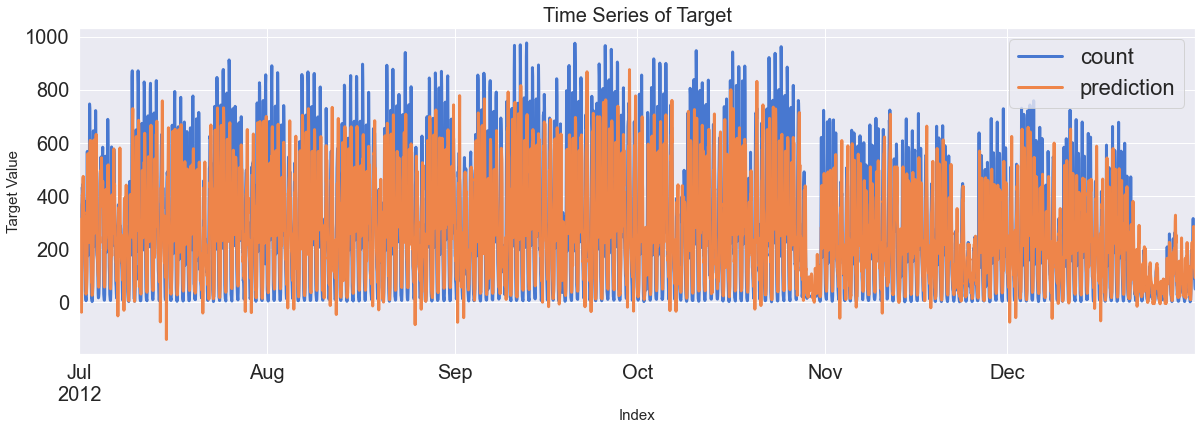

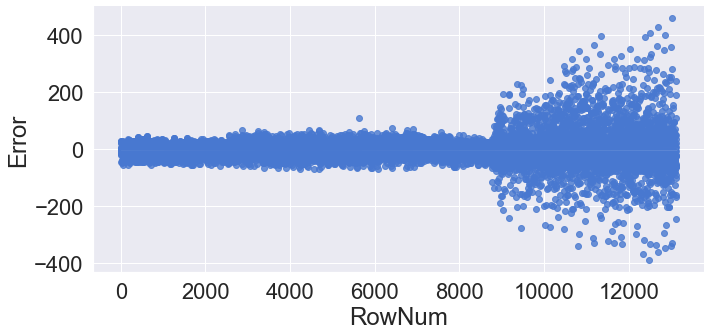

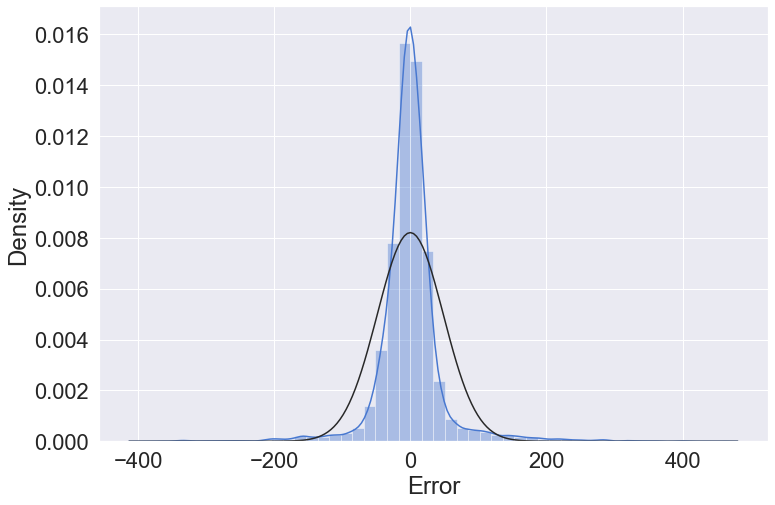

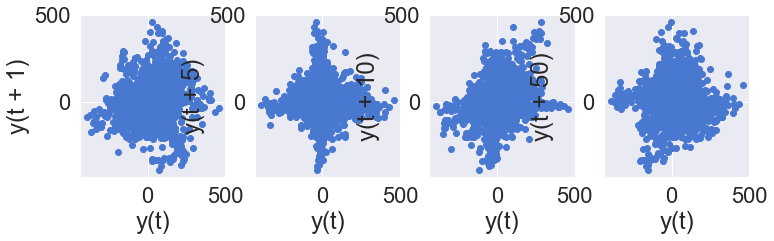

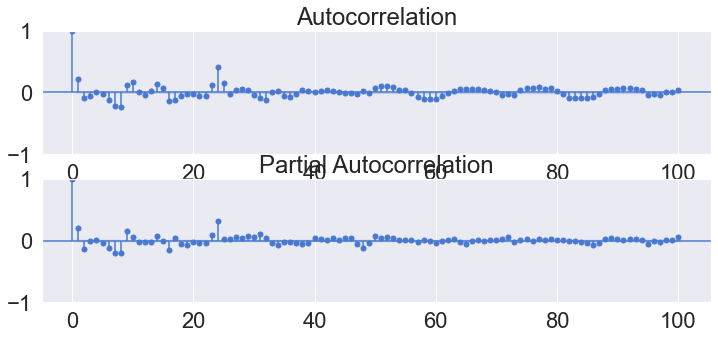

In [18]:
# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############

# Applying Base Model
fit_reg1_feR = sm.OLS(Y_train_feR, X_train_feR).fit()
display(fit_reg1_feR.summary())
pred_tr_reg1_feR = fit_reg1_feR.predict(X_train_feR).values
pred_te_reg1_feR = fit_reg1_feR.predict(X_test_feR).values

# Evaluation
Score_reg1_feR, Resid_tr_reg1_feR, Resid_te_reg1_feR = evaluation_trte(Y_train_feR, pred_tr_reg1_feR,
                                                                   Y_test_feR, pred_te_reg1_feR, graph_on=True)
display(Score_reg1_feR)

# Error Analysis
error_analysis(Resid_tr_reg1_feR, ['Error'], X_train_feR, graph_on=True)

In [26]:
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_train_feR)
X_train_feRS = pd.DataFrame(scaler_fit.transform(X_train_feR), index = X_train_feR.index, columns = X_train_feR.columns)
X_train_feRS.describe().T

,count,mean,std,min,25%,50%,75%,max
season,"13,128.00",0.40,0.35,0.00,0.00,0.33,0.67,1.00
holiday,"13,128.00",0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"13,128.00",0.68,0.46,0.00,0.00,1.00,1.00,1.00
weather,"13,128.00",0.14,0.22,0.00,0.00,0.00,0.33,1.00
temp,"13,128.00",0.48,0.20,0.00,0.31,0.48,0.65,1.00
atemp,"13,128.00",0.46,0.17,0.00,0.32,0.47,0.61,1.00
humidity,"13,128.00",0.62,0.20,0.00,0.47,0.62,0.79,1.00
windspeed,"13,128.00",0.23,0.15,0.00,0.12,0.23,0.33,1.00
count_trend,"13,128.00",0.46,0.24,0.00,0.23,0.50,0.67,1.00
count_seasonal,"13,128.00",0.40,0.28,0.00,0.12,0.44,0.54,1.00


In [27]:
# 미래시점 시계열 정보는 알 수가 없으므로 train에 스케일러를 test에도 사용해야 한다.
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(X_test_feR)
X_test_feRS = pd.DataFrame(scaler_fit.transform(X_test_feR), index = X_test_feR.index, columns = X_test_feR.columns)
X_test_feRS.describe().T

,count,mean,std,min,25%,50%,75%,max
season,"4,416.00",0.79,0.26,0.00,0.67,0.67,1.00,1.00
holiday,"4,416.00",0.03,0.18,0.00,0.00,0.00,0.00,1.00
workingday,"4,416.00",0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,"4,416.00",0.22,0.31,0.00,0.00,0.00,0.50,1.00
temp,"4,416.00",0.47,0.22,0.00,0.26,0.49,0.65,1.00
atemp,"4,416.00",0.48,0.22,0.00,0.28,0.50,0.66,1.00
humidity,"4,416.00",0.57,0.20,0.00,0.40,0.58,0.74,1.00
windspeed,"4,416.00",0.26,0.18,0.00,0.16,0.25,0.39,1.00
count_trend,"4,416.00",0.56,0.18,0.00,0.47,0.59,0.69,1.00
count_seasonal,"4,416.00",0.40,0.28,0.00,0.14,0.45,0.54,1.00


In [30]:
def feature_engineering_scaling(X_train, X_test):
    scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.RobustScaler()
    # scaler = preprocessing.Normalizer()
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), index = X_train.index, columns = X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), index = X_test.index, columns = X_test.columns)
    
    return X_train_scaling, X_test_scaling

In [31]:
X_train_feRS, X_test_feRS = feature_engineering_scaling(X_train_feR, X_test_feR)
X_train_feRS.describe().T

,count,mean,std,min,25%,50%,75%,max
season,"13,128.00",0.40,0.35,0.00,0.00,0.33,0.67,1.00
holiday,"13,128.00",0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,"13,128.00",0.68,0.46,0.00,0.00,1.00,1.00,1.00
weather,"13,128.00",0.14,0.22,0.00,0.00,0.00,0.33,1.00
temp,"13,128.00",0.48,0.20,0.00,0.31,0.48,0.65,1.00
atemp,"13,128.00",0.46,0.17,0.00,0.32,0.47,0.61,1.00
humidity,"13,128.00",0.62,0.20,0.00,0.47,0.62,0.79,1.00
windspeed,"13,128.00",0.23,0.15,0.00,0.12,0.23,0.33,1.00
count_trend,"13,128.00",0.46,0.24,0.00,0.23,0.50,0.67,1.00
count_seasonal,"13,128.00",0.40,0.28,0.00,0.12,0.44,0.54,1.00


Train_size: (13128, 30) Test_size: (4416, 30)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              9185.
Date:                Tue, 12 Jul 2022   Prob (F-statistic):                        0.00
Time:                        11:25:13   Log-Likelihood:                         -71445.
No. Observations:               13128   AIC:                                  1.429e+05
Df Residuals:                   13105   BIC:                                  1.431e+05
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            10.3497      3.281      3.154      0.002       3.918      16.782
holiday          -69.4104      3.425    -20.266      0.000     -76.124     -62.697
workingday       -42.4222      1.588    -26.713      0.000     -45.535     -39.309
weather           -8.8052      2.684     -3.281      0.001     -14.066      -3.545
temp             294.0204     21.652     13.579      0.000     251.579     336.462
atemp           -335.1066     23.735    -14.119      0.000    -381.630    -288.583
humidity         -91.2891      2.877    -31.725      0.000     -96.929     -85.649
windspeed        -82.0334      3.521    -23.301      0.000     -88.934     -75.133
count_trend      -12.0900      6.827     -1.771      0.077     -25.472       1.292
count_seasonal   107.2242      2.927     36.637      0.000     101.488     112.961
count_Day        -10.0271      6.901     -1.453      0.146     -23.553       3.499
count_Week        38.8907      5.060      7.686      0.000      28.973      48.808
count_diff       358.8773      5.519     65.027      0.000     348.060     369.695
Year               7.9341      2.205      3.598      0.000       3.612      12.256
Quater_ver2       13.6867      2.685      5.097      0.000       8.423      18.950
Month            -21.7278      7.134     -3.046      0.002     -35.712      -7.743
Day              -14.0678      1.677     -8.390      0.000     -17.355     -10.781
Hour             -22.8941      2.160    -10.601      0.000     -27.127     -18.661
DayofWeek        -62.4139      2.155    -28.962      0.000     -66.638     -58.190
count_lag1       882.2732      6.808    129.603      0.000     868.929     895.617
count_lag2      -230.1518      6.263    -36.747      0.000    -242.428    -217.875
Quater_Dummy_2     9.9131      2.133      4.649      0.000       5.733      14.093
Quater_Dummy_3     4.8539      3.316      1.464      0.143      -1.646      11.353
Quater_Dummy_4     5.6920      4.777      1.192      0.233      -3.672      15.056
==============================================================================
Omnibus:                     2548.453   Durbin-Watson:                   1.416
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25395.631
Skew:                           0.643   Prob(JB):                         0.00
Kurtosis:                       9.691   Cond. No.                     3.71e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 4.12e-27. This might indicate that there ar

,MAE,MSE,MAPE
Train,38.41,"3,123.02",125.44
Test,113.02,"25,732.59",150.83


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

KeyError: 0

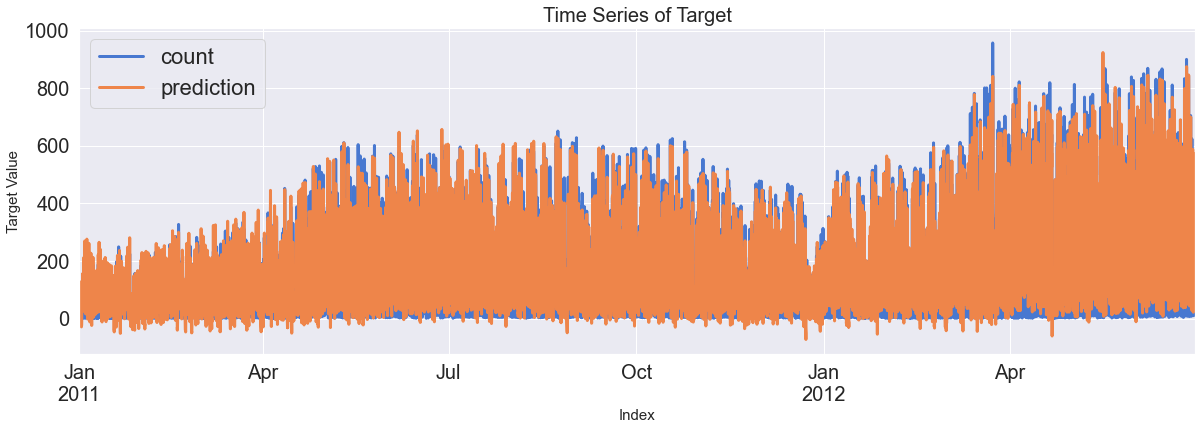

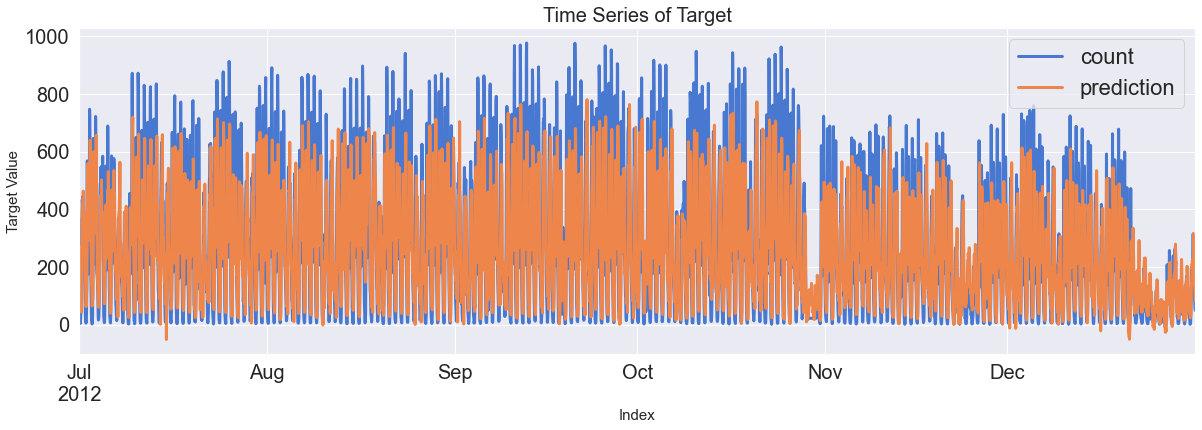

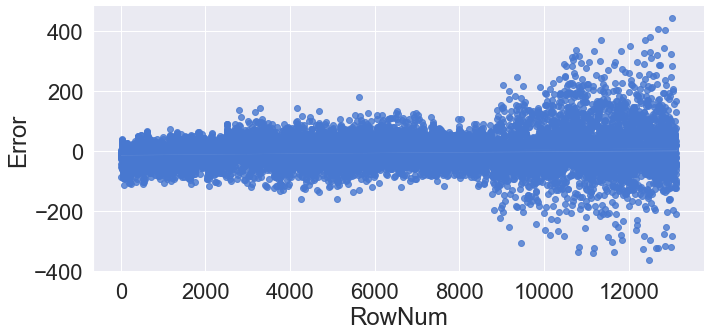

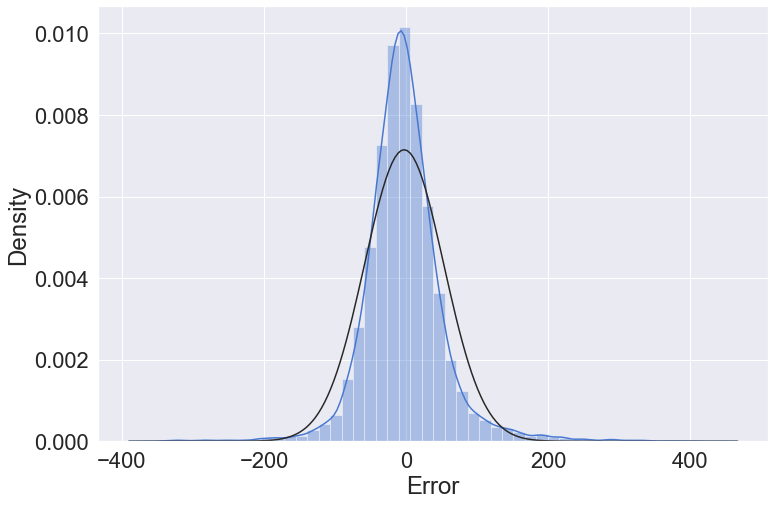

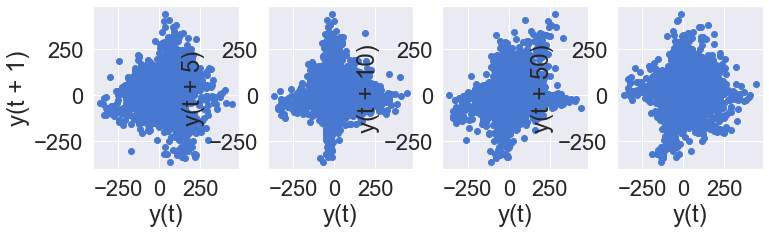

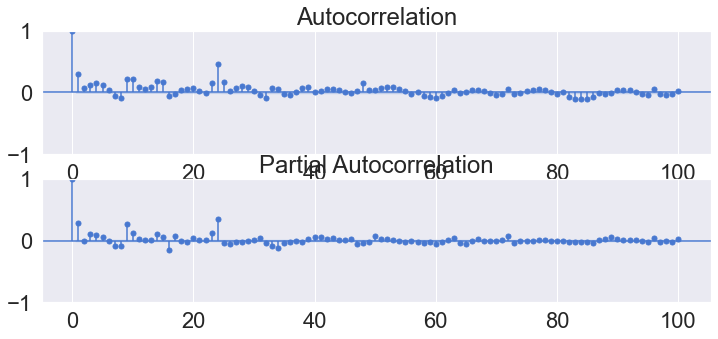

In [32]:
# Feature Engineering
raw_fe = feature_engineering(raw_all)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
raw_feR = feature_engineering_year_duplicated(raw_fe, target)
###############

# Data Split
# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train_feR, X_test_feR, Y_train_feR, Y_test_feR = datasplit_ts(raw_feR, Y_colname, X_colname, '2012-07-01')
### Reality ###
target = ['count_lag1', 'count_lag2']
X_test_feR = feature_engineering_lag_modified(Y_test_feR, X_test_feR, target)
###############
### Scaling ###
X_train_feRS, X_test_feRS = feature_engineering_scaling(X_train_feR, X_test_feR)
###############

# Applying Base Model
fit_reg1_feRS = sm.OLS(Y_train_feR, X_train_feRS).fit()
display(fit_reg1_feRS.summary())
pred_tr_reg1_feRS = fit_reg1_feRS.predict(X_train_feRS).values
pred_te_reg1_feRS = fit_reg1_feRS.predict(X_test_feRS).values

# Evaluation
Score_reg1_feRS, Resid_tr_reg1_feRS, Resid_te_reg1_feRS = evaluation_trte(Y_train_feR, pred_tr_reg1_feRS,
                                                                   Y_test_feR, pred_te_reg1_feRS, graph_on=True)
display(Score_reg1_feRS)

# Error Analysis
error_analysis(Resid_tr_reg1_feRS, ['Error'], X_train_feRS, graph_on=True)